# Multi-Class Classification on "Computer Security" Category

## 1. Imports

In [1]:
import ast
import random
from collections import Counter
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from wordcloud import WordCloud

from preprocess_functions import build_tree, extract_keys, preprocess_texts, map_targets
from utils import CalibratedLabelRankClassifier, ChainOfClassifiers, LabelPowersetClassifier, \
    assess_models, prune_and_subsample, ConditionalDependencyNetwork, MetaBinaryRelevance


## 2. Configurations & Constants

### Global Configuration Constants

In [2]:
OVERWRITE = True
RETRAIN = True
RANDOM_STATE = 42
MODEL_LEVEL = 'computer_security'

### Set Random Seeds

In [3]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Testing Parameters

In [4]:
TEST_SIZE = 2e-1

### Category Mappings

In [5]:
FIX_TARGETS = {
    'network security': 'network security',
    'antivirus and malware': 'antivirus and malware'
}

### Base Models

In [6]:
BASE_CLASSIFIERS = {
    'logistic_regression': LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight='balanced'),
    'gaussian_nb': GaussianNB(),
    'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'random_forest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'xgb': xgb.XGBClassifier(random_state=RANDOM_STATE),
}

### Directory Paths

In [7]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

### Dataset & Model Paths

In [8]:
BINARY_PROBLEMS_DIR = MODELS_DIR / 'binary_problems'
ENSEMBLES_DIR = MODELS_DIR / 'ensembles'
MULTICLASS_PROBLEMS_DIR = MODELS_DIR / 'multiclass_problems'
GLOVE_DIR = MODELS_DIR / 'glove-embeddings'
GLOVE_6B_300D_TXT = GLOVE_DIR / 'glove.6B.300d.txt'

DATASET_DIR = DATA_DIR / 'tweets-dataset-for-cyberattack-detection'
THREAT_TWEETS_CSV = DATASET_DIR / 'tweets_train.csv'

BR_PKL = BINARY_PROBLEMS_DIR / f'br_{MODEL_LEVEL}.pkl'
CLR_PKL = BINARY_PROBLEMS_DIR / f'clr_{MODEL_LEVEL}.pkl'
CC_PKL = BINARY_PROBLEMS_DIR / f'cc_{MODEL_LEVEL}.pkl'

LP_PKL = MULTICLASS_PROBLEMS_DIR / f'lp_{MODEL_LEVEL}.pkl'
PST_PKL = MULTICLASS_PROBLEMS_DIR / f'pst_{MODEL_LEVEL}.pkl'

CDN_PKL = ENSEMBLES_DIR / f'pkl_{MODEL_LEVEL}.pkl'
MBR_PKL = ENSEMBLES_DIR / f'mbr_{MODEL_LEVEL}.pkl'

### Loading Models

In [9]:
br = joblib.load(filename=BR_PKL) if BR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
clr = joblib.load(filename=CLR_PKL) if CLR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cc = joblib.load(filename=CC_PKL) if CC_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
lp = joblib.load(filename=LP_PKL) if LP_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
pst = joblib.load(filename=PST_PKL) if PST_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cdn = joblib.load(filename=CDN_PKL) if CDN_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
mbr = joblib.load(filename=MBR_PKL) if MBR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest for the category 'computer security' are:
1. mac os
2. windows
3. unix
4. linux

In [10]:
threat_tweets = (
    pd.read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
    .assign(
        tweet=lambda df: df['tweet'].apply(func=ast.literal_eval),
        watson=lambda df: df['watson'].apply(func=ast.literal_eval)
        .apply(func=lambda x: x.get('categories', []))
        .apply(func=build_tree),
        watson_list=lambda df: df['watson'].apply(func=extract_keys),
        target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,))
    )
    .query(expr='relevant == True')
    .drop(labels=[
        'relevant', '_id', 'date',
        'id', 'tweet', 'type',
        'annotation', 'urls', 'destination_url',
        'valid_certificate'
    ], axis=1)
    .dropna(subset=['text'], ignore_index=True)
)

threat_tweets = threat_tweets[
    threat_tweets["watson_list"].apply(lambda x: ' '.join(MODEL_LEVEL.split(sep='_')) in x)
].reset_index(drop=True)

print(f"Threat Tweets: {len(threat_tweets)}")
threat_tweets.head()

Threat Tweets: 4653


,text,watson,watson_list,target
0,Protonmail DDoS Attacks: British Bomb Threat T...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[antivirus and malware]
1,Watched GoT for the first #shellshock vulnerab...,"{'society': {'unrest and war': {}}, 'technolog...","[society, unrest and war, technology and compu...","[network security, antivirus and malware]"
2,U.K. Teen Involved in ProtonMail DDoS Attack A...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[antivirus and malware]
3,.@CenturyLink Francis Prince Thangasamy shares...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[antivirus and malware]
4,EOEO Virus Removal – Restore Infected Computer...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[antivirus and malware]


## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [11]:
all_words = ' '.join(threat_tweets['text']).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('the', 1180), ('a', 1097), ('to', 953), ('of', 928), ('in', 878), ('vulnerability', 827), ('and', 692), ('Vulnerability', 641), ('DDoS', 578), ('-', 512)]


#### 4.1.2. Word Cloud

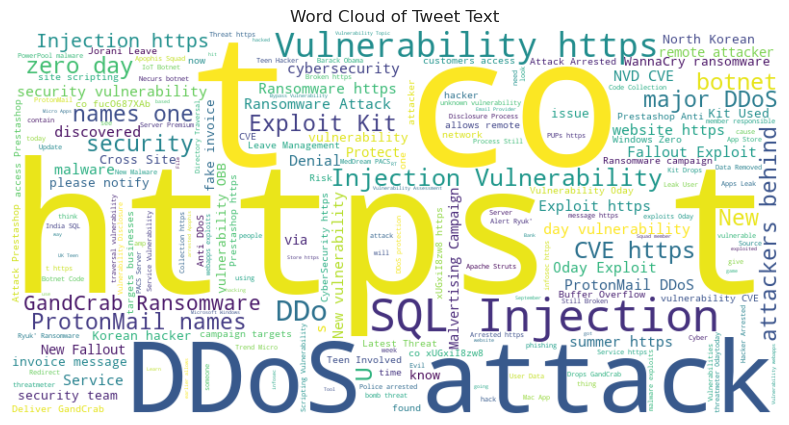

In [12]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text=' '.join(threat_tweets['text']))

plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

#### 4.1.3. Text Length Distribution

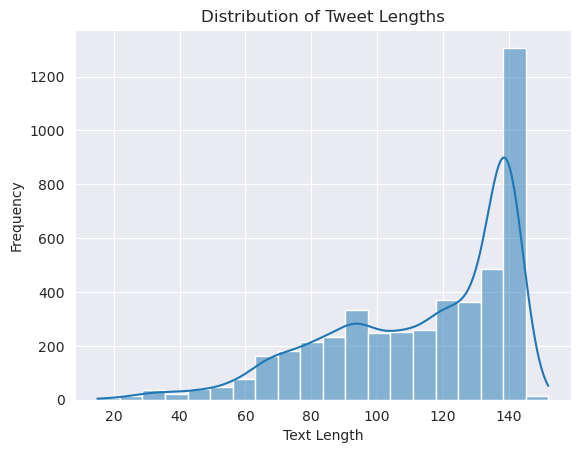

In [13]:
threat_tweets['text_length'] = threat_tweets['text'].apply(func=len)
sns.histplot(
    data=threat_tweets['text_length'],
    bins=20,
    kde=True
)
plt.title(label='Distribution of Tweet Lengths')
plt.xlabel(xlabel='Text Length')
plt.ylabel(ylabel='Frequency')
plt.show()

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [14]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in threat_tweets['watson_list'] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 4653), ('computer security', 4653), ('antivirus and malware', 3412), ('network security', 1698), ('software', 1545), ('hardware', 736), ('computer', 634), ('society', 633), ('databases', 611), ('business and industrial', 517)]


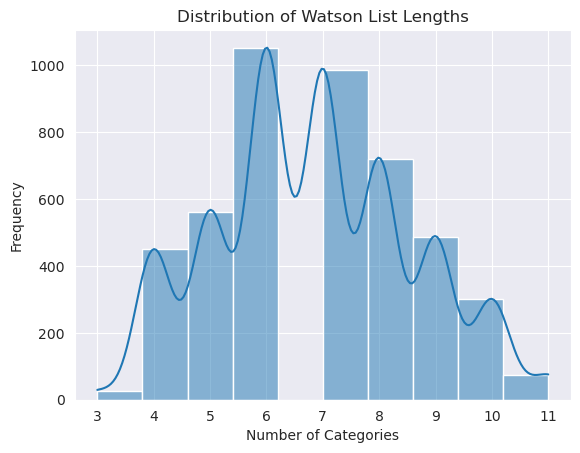

In [15]:
# Category Depth Analysis
threat_tweets['watson_list_length'] = threat_tweets['watson_list'].apply(func=len)

sns.histplot(
    data=threat_tweets['watson_list_length'],
    bins=10,
    kde=True
)

plt.title(label='Distribution of Watson List Lengths')
plt.xlabel(xlabel='Number of Categories')
plt.ylabel(ylabel='Frequency')
plt.show()

In [16]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in threat_tweets['watson_list']:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'computer security'), 4653), (('technology and computing', 'antivirus and malware'), 3412), (('computer security', 'antivirus and malware'), 3412), (('technology and computing', 'network security'), 1698), (('computer security', 'network security'), 1698), (('technology and computing', 'software'), 1545), (('computer security', 'software'), 1056), (('antivirus and malware', 'software'), 779), (('technology and computing', 'hardware'), 736), (('technology and computing', 'computer'), 634)]


In [17]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('computer', 5621), ('technology', 4653), ('antivirus', 3412), ('network', 1733), ('software', 1546), ('hardware', 736), ('society', 633), ('databases', 611), ('business', 556), ('law,', 516), ('crime', 475), ('personal', 366), ('art', 334), ('health', 330), ('science', 328), ('operating', 289), ('assault', 268), ('programming', 254), ('hobbies', 224), ('law', 194), ('consumer', 185), ('finance', 179), ('police', 178), ('networking', 174), ('weather', 165), ('meteorological', 158), ('internet', 152), ('disorders', 152), ('javascript', 150), ('government', 147), ('flood', 145), ('vpn', 139), ('property', 136), ('sports', 135), ('home', 135), ('bank', 133), ('disease', 131), ('mental', 131), ('games', 124), ('movies', 123), ('legal', 118), ('food', 111), ('panic', 109), ('music', 98), ('windows', 94), ('role', 93), ('java', 92), ('energy', 87), ('travel', 82), ('game', 80), ('shopping', 79), ('linux', 77), ('xbox', 75), ('legislation', 70), ('company', 65

### 4.4. Target Analysis

Target Frequencies:
antivirus and malware: 2907
network security: 1698
other: 48


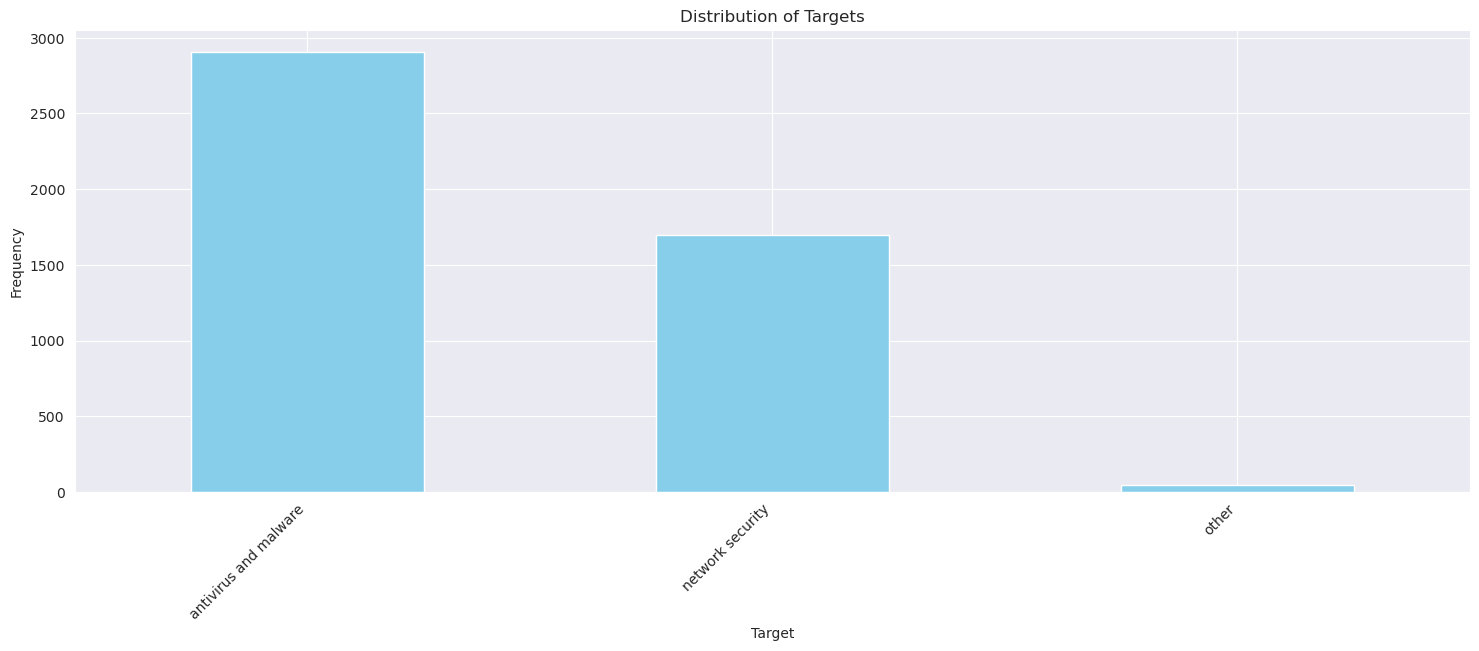

In [18]:
class_freq = Counter([item[0] for item in threat_tweets['target']])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('antivirus and malware',): 2907
('network security',): 1193
('network security', 'antivirus and malware'): 505
('other',): 48


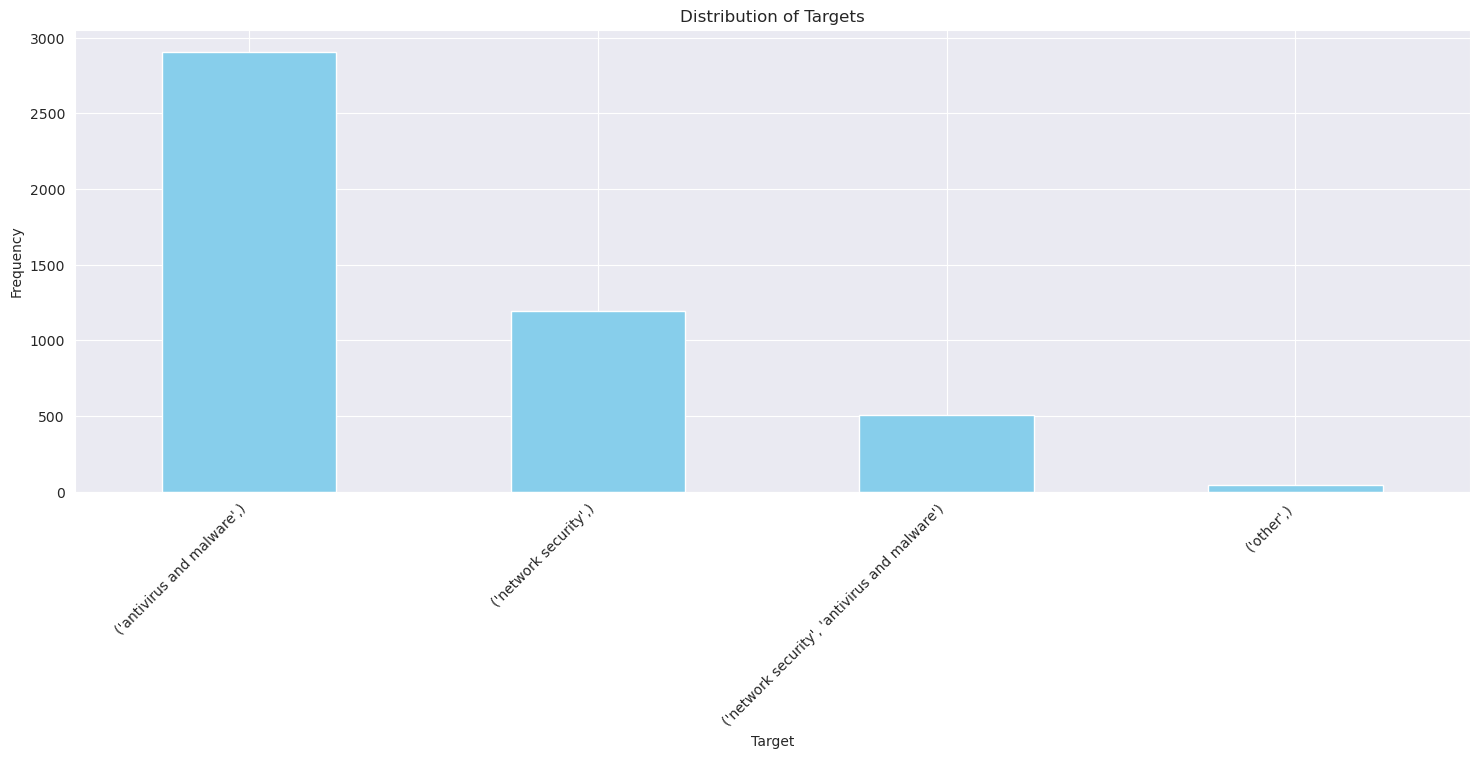

In [19]:
target_freq = Counter(tuple(item) for item in threat_tweets['target'])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [20]:
# Multi-Label Analysis
multi_label_counts = threat_tweets['target'].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 505


In [21]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(threat_tweets['target'], threat_tweets['text'])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=['target', 'text'])

for target in class_freq:
    target_texts = target_text_df[target_text_df['target'].apply(func=lambda x: target in x)]['text']
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'antivirus and malware':
https            3503
ddos             1055
vulnerability     787
ransomware        610
injection         424
sql               410
exploit           406
attack            351
botnet            324
new               298
dtype: int64
Top 10 words for target 'network security':
https            1763
vulnerability    1492
security          464
cve               299
2018              233
new               138
nvd                86
service            85
denial             82
injection          81
dtype: int64
Top 10 words for target 'other':
https         56
security      27
ransomware    19
cyber         18
hacker        17
attack        13
data           9
new            8
breach         7
granite        6
dtype: int64


## 5. Feature Engineering

In [22]:
# Find valid targets (with frequency ≥ 5)
valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
filtered_df = threat_tweets[threat_tweets['target'].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in filtered_df['target'])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

Updated Target Frequencies:
('antivirus and malware',): 2907
('network security',): 1193
('network security', 'antivirus and malware'): 505
('other',): 48


Preprocess the `text` column into embeddings

In [23]:
X = preprocess_texts(
    list_str=filtered_df['text'],
    model_path=GLOVE_6B_300D_TXT,
    embedding_dim=300
)

Convert the `target` column into a binary multi-label matrix

In [24]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=filtered_df['target'])

Create a dictionary that maps label indices to unique label sets

In [25]:
unique_label_sets, y_lp = np.unique(ar=y, axis=0, return_inverse=True)
label_map_lp = {i: tuple(lbl_set) for i, lbl_set in enumerate(unique_label_sets)}

Perform pruning and subsampling of the dataset to remove infrequent targets

In [26]:
X_pst, y_pst, label_map_pst, _ = prune_and_subsample(
    x=X,
    y=y,
    pruning_threshold=np.median(np.array(list(target_freq.values()))) * .25,
    max_sub_samples=round(np.median(np.array(list(target_freq.values()))) * .25)
)

In [27]:
smote = SMOTE(random_state=42)
X, y_lp = smote.fit_resample(X, y_lp)
y = np.array(unique_label_sets[y_lp])
print(f"{X.shape}, {len(y_lp)}")

(11628, 300), 11628


## 6. Model Training

In [28]:
# BR, CLR, CC, CDN, MBR, LP
X_train, X_val, y_train, y_val, y_train_lp, y_val_lp = train_test_split(
    X, y, y_lp,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_lp
)

print(f"{'Training:':<15}\tX = {str(X_train.shape[0]) + ' × ' + str(X_train.shape[1]):<15}\ty = {str(y_train.shape[0]) + ' × ' + str(y_train.shape[1]):<15}")
print(f"{'Validation:':<15}\tX = {str(X_val.shape[0]) + ' × ' + str(X_val.shape[1]):<15}\ty = {str(y_val.shape[0]) + ' × ' + str(y_val.shape[1]):<15}")

Training:      	X = 9302 × 300     	y = 9302 × 3       
Validation:    	X = 2326 × 300     	y = 2326 × 3       


In [29]:
# PSt
X_train_pst, X_val_pst, y_train_pst, y_val_pst = train_test_split(
    X_pst, y_pst,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_pst
)
print(
    f"{'Training:':<15}\tX = {str(X_train_pst.shape[0]) + ' × ' + str(X_train_pst.shape[1]):<15}\ty = {str(len(y_train_pst)):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val_pst.shape[0]) + ' × ' + str(X_val_pst.shape[1]):<15}\ty = {str((len(y_val_pst))):<15}")

Training:      	X = 3684 × 300     	y = 3684           
Validation:    	X = 921 × 300      	y = 921            


### 4.1. Binary Problems


#### 4.1.1. BR (Binary Relevance)


In [30]:
if RETRAIN:
    for k in tqdm(BASE_CLASSIFIERS.keys()):
        br[k] = OneVsRestClassifier(estimator=BASE_CLASSIFIERS[k]).fit(X=X_train, y=y_train)

100%|██████████| 5/5 [01:13<00:00, 14.66s/it]


#### 4.1.2. CLR (Calibrated Label Ranking)


In [31]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = CalibratedLabelRankClassifier(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        clr[k] = model.fit(
            x=X_train,
            y=[list(mlb.classes_[np.where(row == 1)[0]]) for row in y_train]
        )

100%|██████████| 5/5 [02:08<00:00, 25.61s/it]


#### 4.1.3. CC (Classifier Chains)


In [32]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ChainOfClassifiers(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        cc[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 5/5 [01:09<00:00, 13.92s/it]


### 4.2. Multi-class Problems



#### 4.2.1. LP (Label Powerset)


In [33]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_lp,
            random_state=RANDOM_STATE
        )

        lp[k] = model.fit(
            x=X_train,
            y=y_train_lp
        )

100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


#### 4.2.2. PSt (Pruned Sets)


In [34]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_pst,
            random_state=RANDOM_STATE
        )

        pst[k] = model.fit(
            x=X_train_pst,
            y=y_train_pst
        )

100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


### 4.3. Ensembles


#### 4.3.1. CDN (Conditional Dependency Network)


In [35]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ConditionalDependencyNetwork(
            classifier=v,
            num_iterations=100,
            burn_in=10
        )

        cdn[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 5/5 [00:56<00:00, 11.34s/it]


#### 4.3.2. MBR (Meta-Binary Relevance)


In [36]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = MetaBinaryRelevance(
            classifier=v,
            use_cross_val=True,
            n_splits=5
        )

        mbr[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 5/5 [08:01<00:00, 96.23s/it] 


## 7. Model Evaluation

In [37]:
performances = {}

### 7.1. Binary Problems



#### 7.1.1. BR (Binary Relevance)


In [38]:
performances['BR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=br,
    classes=mlb.classes_
)

In [39]:
y_val_hat = performances['BR']['Model'].predict(X_val)
print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.98      0.98      0.98      1163
     network security       0.97      0.98      0.98      1162
                other       1.00      1.00      1.00       582

            micro avg       0.98      0.99      0.98      2907
            macro avg       0.98      0.99      0.99      2907
         weighted avg       0.98      0.99      0.98      2907
          samples avg       0.98      0.99      0.98      2907

Accuracy:	0.9673
AUC:	0.9867


#### 7.1.2. CLR (Calibrated Label Ranking)


In [40]:
performances['CLR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=clr,
    classes=mlb.classes_
)

In [41]:
y_val_hat = performances['CLR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.98      0.98      0.98      1163
     network security       0.97      0.99      0.98      1162
                other       1.00      1.00      1.00       582

            micro avg       0.98      0.99      0.99      2907
            macro avg       0.98      0.99      0.99      2907
         weighted avg       0.98      0.99      0.99      2907
          samples avg       0.98      0.99      0.98      2907

Accuracy:	0.9682
AUC:	0.9877


#### 7.1.3. CC (Classifier Chains)


In [42]:
performances['CC'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cc,
    classes=mlb.classes_
)

In [43]:
y_val_hat = performances['CC']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.98      0.98      0.98      1163
     network security       0.98      0.98      0.98      1162
                other       1.00      1.00      1.00       582

            micro avg       0.98      0.99      0.98      2907
            macro avg       0.99      0.99      0.99      2907
         weighted avg       0.98      0.99      0.98      2907
          samples avg       0.98      0.99      0.98      2907

Accuracy:	0.9738
AUC:	0.9872


### 7.2. Multi-class Problems




#### 7.2.1. LP (Label Powerset)



In [44]:
performances['LP'] = assess_models(
    x=X_val,
    y=np.array([list(label_map_lp[yp]) for yp in y_val_lp]),
    technique=lp,
    classes=mlb.classes_
)

In [45]:
y_val_hat = performances['LP']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.98      0.98      0.98      1163
     network security       0.98      0.98      0.98      1162
                other       1.00      1.00      1.00       582

            micro avg       0.99      0.98      0.98      2907
            macro avg       0.99      0.99      0.99      2907
         weighted avg       0.99      0.98      0.98      2907
          samples avg       0.98      0.98      0.98      2907

Accuracy:	0.9781
AUC:	0.9874


#### 7.2.2. PSt (Pruned Sets)


In [46]:
performances['PST'] = assess_models(
    x=X_val_pst,
    y=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    technique=pst,
    classes=mlb.classes_
)

In [47]:
y_val_hat = performances['PST']['Model'].predict(X_val_pst)

print(classification_report(
    y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(
    f"Accuracy:\t{accuracy_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_pred=y_val_hat):.4f}")
try:
    print(
        f"AUC:\t{roc_auc_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_score=y_val_hat):.4f}")
except ValueError:
    print(f"AUC:\tNot defined")

                       precision    recall  f1-score   support

antivirus and malware       0.94      0.95      0.95       682
     network security       0.95      0.81      0.87       340
                other       0.00      0.00      0.00         0

            micro avg       0.94      0.91      0.93      1022
            macro avg       0.63      0.59      0.61      1022
         weighted avg       0.94      0.91      0.92      1022
          samples avg       0.94      0.92      0.93      1022

Accuracy:	0.8936
AUC:	Not defined


### 7.3. Ensembles


#### 7.3.1. CDN (Conditional Dependency Network)


In [48]:
performances['CDN'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cdn,
    classes=mlb.classes_
)

In [49]:
y_val_hat = performances['CDN']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.88      0.92      0.90      1163
     network security       0.94      0.91      0.92      1162
                other       0.98      1.00      0.99       582

            micro avg       0.92      0.93      0.93      2907
            macro avg       0.93      0.94      0.94      2907
         weighted avg       0.93      0.93      0.93      2907
          samples avg       0.93      0.93      0.92      2907

Accuracy:	0.8633
AUC:	0.9406


#### 7.3.2. MBR (Meta-Binary Relevance)


In [50]:
performances['MBR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=mbr,
    classes=mlb.classes_
)

In [51]:
y_val_hat = performances['MBR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.98      0.99      0.98      1163
     network security       0.98      0.99      0.99      1162
                other       1.00      1.00      1.00       582

            micro avg       0.99      0.99      0.99      2907
            macro avg       0.99      0.99      0.99      2907
         weighted avg       0.99      0.99      0.99      2907
          samples avg       0.98      0.99      0.99      2907

Accuracy:	0.9789
AUC:	0.9900


## 8. Summary


In [52]:
performances = pd.DataFrame(performances).T
performances

,Accuracy,Classifier,Model,Precision example-based,Recall example-based,F1 example-based,Hamming loss,Micro precision,Micro recall,Micro F1,Macro precision,Macro recall,Macro F1,Coverage,Classification
BR,0.967326,xgb,OneVsRestClassifier(estimator=XGBClassifier(ba...,0.978289,0.985383,0.980224,0.013328,0.980861,0.987272,0.984056,0.984079,0.989391,0.986722,1.295787,precision recall f1...
CLR,0.968186,xgb,CalibratedLabelRankClassifier(classes=array(['...,0.980439,0.988177,0.982516,0.012324,0.981235,0.989336,0.985269,0.984103,0.991112,0.987588,1.291917,precision recall f1...
CC,0.973775,xgb,ChainOfClassifiers(classes=array(['antivirus a...,0.983233,0.985598,0.983233,0.012754,0.982865,0.986584,0.984721,0.98573,0.988817,0.98727,1.288048,precision recall f1...
LP,0.978074,xgb,LabelPowersetClassifier(classifier=XGBClassifi...,0.982803,0.982373,0.982087,0.012611,0.985198,0.98452,0.984859,0.987664,0.987097,0.987379,1.287618,precision recall f1...
PST,0.893594,xgb,LabelPowersetClassifier(classifier=XGBClassifi...,0.942997,0.920738,0.927615,0.053927,0.944954,0.907045,0.925612,0.630018,0.58877,0.607696,1.271444,precision recall f1...
CDN,0.866294,logistic_regression,ConditionalDependencyNetwork(classifier=Logist...,0.929493,0.936586,0.925623,0.05804,0.926962,0.934297,0.930615,0.935019,0.944946,0.939867,1.428203,precision recall f1...
MBR,0.978934,xgb,MetaBinaryRelevance(classifier=XGBClassifier(b...,0.984523,0.987532,0.985239,0.010032,0.986621,0.989336,0.987977,0.988856,0.991111,0.989981,1.282459,precision recall f1...


In [53]:
if OVERWRITE:
    joblib.dump(br, BR_PKL, compress=9)
    joblib.dump(clr, CLR_PKL, compress=9)
    joblib.dump(cc, CC_PKL, compress=9)
    joblib.dump(lp, LP_PKL, compress=9)
    joblib.dump(pst, PST_PKL, compress=9)
    joblib.dump(cdn, CDN_PKL, compress=9)
    joblib.dump(mbr, MBR_PKL, compress=9)